In [1]:
# base imports
import sys
import importlib

# third party
import matplotlib.pyplot as plt

In [2]:
# Path to the directory containing the Python file
module_path = '../simulation_test/'

# Add the directory to sys.path
if module_path not in sys.path:
    sys.path.append(module_path)

module_path = '../pkg/pyepo/func/'

# Add the directory to sys.path
if module_path not in sys.path:
    sys.path.append(module_path)

In [200]:
from matplotlib import pyplot as plt

def visLearningCurve(loss_log, loss_log_regret):
    # create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    # draw plot for training loss
    ax1.plot(loss_log, color="c", lw=1)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    # draw plot for regret on test
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.5)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

## Components for Reproducing DSL ICML Numericals
For decision-aware/predict-then-optimize setting in PyEPO, we need three things
* Data - Done
* Optimization Model
* Prediction Model

## Data Check

In [3]:
import dsl_icml_data
importlib.reload(dsl_icml_data)

from dsl_icml_data import *

Auto-Sklearn cannot be imported.


In [22]:
x_config = {'x_min': 0,
            'x_max': 2}
exp_y_config = {'m':0, 
               'm0':-4,
               'c0':-0.2}
noise_config = {'alpha':1,
                'expon_offset':0.5,
                'expon_rate':0.5,
                'norm_std':0.25}

x, exp_y, noise, y = gen_data_instance(n=2000,
                                      noise_config=noise_config)

(-7.5, 2.5)

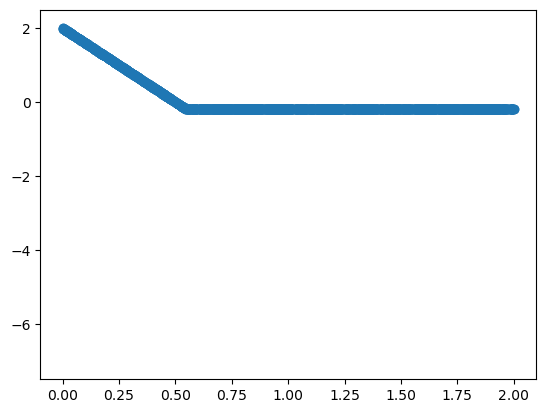

In [23]:
# check if exp_y is correct by plotting

# Creating the scatterplot
plt.scatter(x, exp_y)
plt.ylim(-7.5, 2.5)

## TODO: weird that the noise here is all positive leaning but mike's code generates negative leaning

(-7.5, 2.5)

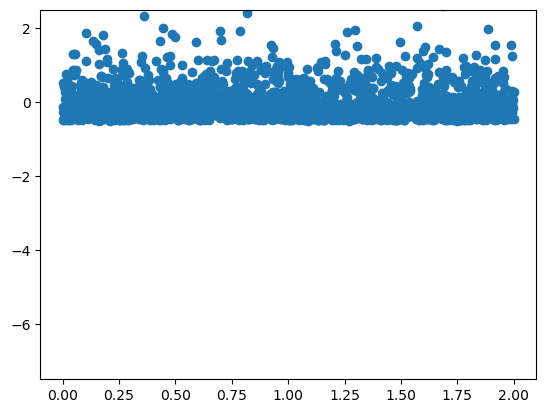

In [30]:
# check noise
plt.scatter(x, noise)
plt.ylim(-7.5, 2.5)

(-7.5, 2.5)

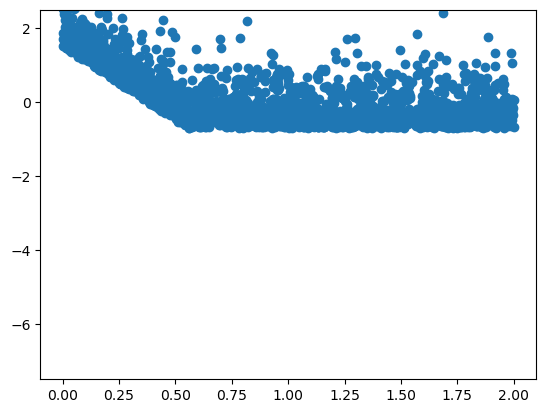

In [29]:
# check noisy y
plt.scatter(x, y)
plt.ylim(-7.5, 2.5)

In [31]:
# check if noise is correct by seeing if it is exp rv with mean 0.5 and epsilon based on paper
noise_mean = noise.mean()
noise_var = noise.var()

print(f'mean noise is {noise_mean}')
print(f'var noise is {noise_var}')

mean noise is -0.01154421483466016
var noise is 0.22601058556549608


### Prediction and Optimization Model

In [154]:
import dsl_icml_model
importlib.reload(dsl_icml_model)
from dsl_icml_model import *

In [155]:
reg = LinearRegression(1,1)
condLinOpt_grb = icmlCondLinOptModel_gurobi()
condLinOpt = icmlCondLinOptModel()

In [138]:
noise_config = {'alpha':1,
                'expon_offset':0.5,
                'expon_rate':0.5,
                'norm_std':0.25}

x_train, exp_y_train, noise_train, y_train = gen_data_instance(n=200,
                                      noise_config=noise_config)
x_test, exp_y_test, noise_test, y_test = gen_data_instance(n=1000,
                                      noise_config=noise_config)

(-7.5, 2.5)

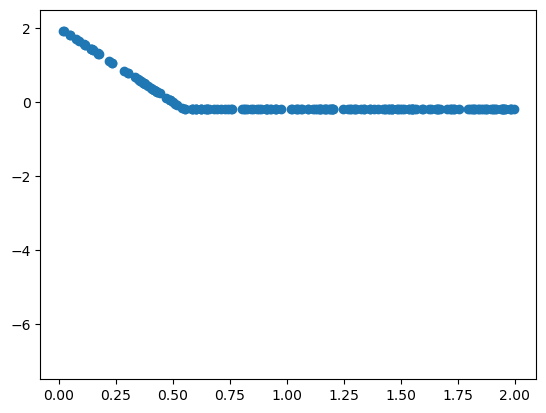

In [49]:
# check noise
plt.scatter(x_train, exp_y_train)
plt.ylim(-7.5, 2.5)

In [262]:
# get optDataset
dataset_train = pyepo.data.dataset.optDataset(condLinOpt, x_train, y_train)
dataset_test = pyepo.data.dataset.optDataset(condLinOpt, x_test, exp_y_test)

Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 234318.66it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 266796.26it/s]


In [140]:
dataset_train_grb = pyepo.data.dataset.optDataset(condLinOpt_grb, x_train, exp_y_train)
dataset_test_grb = pyepo.data.dataset.optDataset(condLinOpt_grb, x_test, exp_y_test)

Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 5776.40it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 6044.88it/s]


In [39]:
print(f'customized model train data {dataset_train[:5]}')
print(f'grb model train data {dataset_train_grb[:5]}')

customized model train data (tensor([[0.6808],
        [1.5084],
        [0.1552],
        [1.2898],
        [0.6008]]), tensor([[-0.2000],
        [-0.2000],
        [ 1.3790],
        [-0.2000],
        [-0.2000]]), tensor([[-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.]]), tensor([[0.2000],
        [0.2000],
        [1.3790],
        [0.2000],
        [0.2000]]))
grb model train data (tensor([[0.6808],
        [1.5084],
        [0.1552],
        [1.2898],
        [0.6008]]), tensor([[-0.2000],
        [-0.2000],
        [ 1.3790],
        [-0.2000],
        [-0.2000]]), tensor([[-1.],
        [-1.],
        [ 1.],
        [-1.],
        [-1.]]), tensor([[0.2000],
        [0.2000],
        [1.3790],
        [0.2000],
        [0.2000]]))


Check first 100 rows are the same

In [45]:
train_sol_same = (dataset_train[:][2] == dataset_train_grb[:][2]).all()
train_obj_same = (dataset_train[:][3] == dataset_train_grb[:][3]).all()
print(f'all opt sol are same {train_sol_same}')
print(f'all opt obj are same {train_obj_same}')

all opt sol are same True
all opt obj are same True


In [263]:
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Optimization Model Check

In [48]:
# mike's icml code
import dsl_icml_mike_code
importlib.reload(dsl_icml_mike_code)
import dsl_icml_mike_code as dimc

In [54]:
def convert_min_to_max_obj(v):
    return -v

In [55]:
convert_min_to_max_obj(dimc.V_func(np.array([3])))

3

In [51]:
condLinOpt.setObj([3])
condLinOpt.solve()

([1], 3)

In [92]:
condLinOpt_grb.setObj([3])
condLinOpt_grb.solve()

([1.0], 3.0)

## DSL Implementation Check

In [128]:
import dsl_icml_model
importlib.reload(dsl_icml_model)
from dsl_icml_model import *

import dsl as DSL
importlib.reload(DSL)

# mike's icml code
import dsl_icml_mike_code
importlib.reload(dsl_icml_mike_code)
import dsl_icml_mike_code as dimc

from pyepo.utlis import getArgs

In [99]:
h = len(dataset_train) ** (-1/4)

In [130]:
# init DSL loss
dsl = DSL.DSLoss(optmodel=condLinOpt_grb, 
                 h=h,
                 finite_diff_sch='C',
                 processes=0)

Num of cores: 24


One forward pass of dsl

In [135]:
x, true_c, true_s, true_o = dataset_train[:100]
pred = np.random.rand(len(true_c)).reshape(-1,1)

In [127]:
### Forward pass of dsl to get dsl loss
dsl(pred_cost=torch.FloatTensor(pred),
    true_cost=true_c,
    true_sol=true_s,
    true_obj=true_o)

> /home1/yongpeng/PyEPO_DSL/pkg/pyepo/func/dsl.py(134)forward()
    132         pdb.set_trace()
    133         # Calculate loss - a function of cp, c, h
--> 134         loss = step_size * (obj_plus - obj_minus)
    135 
    136         # sense



ipdb>  p obj_plus.sum()


3.2239295840263367


ipdb>  p obj_minus.sum()


2.9159956872463226


ipdb>  p loss


*** NameError: name 'loss' is not defined


ipdb>  n


> /home1/yongpeng/PyEPO_DSL/pkg/pyepo/func/dsl.py(137)forward()
    135 
    136         # sense
--> 137         if optmodel.modelSense == EPO.MINIMIZE:
    138             loss = np.array(loss)
    139         if optmodel.modelSense == EPO.MAXIMIZE:



ipdb>  p loss


array([-0.20000011, -0.2       ,  1.3790087 , -0.2       , -0.2       ])


ipdb>  p loss.mean()


0.11580171646970672


ipdb>  p obj_plus.sum() - obj_minus.sum()


0.30793389678001404


ipdb>  p step_size * (obj_plus.mean() - obj_minus.mean())


0.11580171646970662


ipdb>  p -obj_minus.sum()


-2.9159956872463226


ipdb>  p obj_plus.sum() + -1*obj_minus.sum()


0.30793389678001404


ipdb>  p step_size*(obj_plus.sum() + -1*obj_minus.sum())


0.5790085823485335


ipdb>  p obj_plus.sum()


3.2239295840263367


ipdb>  p -1*obj_minus.sum()


-2.9159956872463226


ipdb>  p step_size*(obj_plus.sum() - obj_minus.sum())


0.5790085823485335


ipdb>  p loss.mean()


0.11580171646970672


ipdb>  p loss.mean()*len(loss)


0.5790085823485336


ipdb>  q


In [126]:
dimc.DSL(pred=-1*pred,
         y_hat=-1*true_c.detach().to("cpu").numpy(),
         h=h)

> /home1/yongpeng/PyEPO_DSL/simulation_test/dsl_icml_mike_code.py(50)DSL()
     48     est_obj_2_s = - V_func(pred - h * y_hat)
     49     pdb.set_trace()
---> 50     return (est_obj_1_s + est_obj_2_s)/(2*h)
     51 
     52 def DSL_fwd(pred, y_hat, h):



ipdb>  p est_obj_1_s


-3.223929568897496


ipdb>  p est_obj_2_s


2.9159955827105146


ipdb>  p (est_obj_1_s + est_obj_2_s)/(2*h)


-0.5790087504605921


ipdb>  q


In [136]:
dsl(pred_cost=torch.FloatTensor(pred),
    true_cost=true_c,
    true_sol=true_s,
    true_obj=true_o)*len(pred)

tensor(-2.5114)

In [137]:
dimc.DSL(pred=-1*pred,
         y_hat=-1*true_c.detach().to("cpu").numpy(),
         h=h)

-2.511355619557378

### Conclusion - forward pass is same up to number of samples

In [268]:
import dsl_icml_model
importlib.reload(dsl_icml_model)
from dsl_icml_model import *

import dsl as DSL
importlib.reload(DSL)

# mike's icml code
import dsl_icml_mike_code
importlib.reload(dsl_icml_mike_code)
import dsl_icml_mike_code as dimc

import dsl_icml_model
importlib.reload(dsl_icml_model)
from dsl_icml_model import *

from pyepo.utlis import getArgs

In [269]:
reg = LinearRegression(1,1)
condLinOpt_grb = icmlCondLinOptModel_gurobi()
condLinOpt = icmlCondLinOptModel()

In [270]:
noise_config = {'alpha':1,
                'expon_offset':0.5,
                'expon_rate':0.5,
                'norm_std':0.25}

x_train, exp_y_train, noise_train, y_train = gen_data_instance(n=200,
                                      noise_config=noise_config)
x_test, exp_y_test, noise_test, y_test = gen_data_instance(n=10000,
                                      noise_config=noise_config)

In [271]:
# get optDataset
dataset_train = pyepo.data.dataset.optDataset(condLinOpt, x_train, y_train)
dataset_test = pyepo.data.dataset.optDataset(condLinOpt, x_test, exp_y_test)

Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 247087.13it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 258636.25it/s]


In [273]:
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Base Regression

In [322]:
# sklearn regressor
from sklearn.linear_model import LinearRegression as sk_lr
reg = sk_lr() # linear regression

# # build model
# twostage_model = pyepo.twostage.sklearnPred(reg)

# training
reg.fit(x_train, y_train)

# prediction
c_pred = reg.predict(x)

# DSL

In [357]:
use_opt_model = condLinOpt

In [358]:
len(dataset_train) ** (-1/4)

0.26591479484724945

In [362]:
h = 5

# init DSL loss
dsl = DSL.DSLoss(optmodel=use_opt_model, 
                 h=h,
                 finite_diff_sch='B',
                 processes=0)

# init model
reg_dsl = LinearRegression(1,1)

## intiialization
reg_dsl.linear.weight.data = torch.tensor(reg.coef_).float()
reg_dsl.linear.bias.data = torch.tensor(reg.intercept_).float()

# cuda
if torch.cuda.is_available():
    reg = reg.cuda()
    
loss_log, loss_log_regret = trainModel(reg_dsl, 
                                       loss_func=dsl,
                                       optmodel=use_opt_model,
                                       loader_train=loader_train,
                                       loader_test=loader_test,
                                       num_epochs=100)

Num of cores: 24
Epoch  1,  Loss:    0.2681,  Regret: 23.4954%
Epoch  2,  Loss:    0.2543,  Regret: 17.2012%
Epoch  3,  Loss:    0.7395,  Regret: 10.7039%
Epoch  4,  Loss:    0.2756,  Regret:  5.0187%
Epoch  5,  Loss:    0.3767,  Regret:  0.4431%
Epoch  6,  Loss:    0.6836,  Regret:  1.2035%
Epoch  7,  Loss:    0.2074,  Regret:  7.4117%
Epoch  8,  Loss:    0.3581,  Regret: 15.4491%
Epoch  9,  Loss:   -0.0662,  Regret: 31.5549%
Epoch 10,  Loss:    0.5034,  Regret: 49.9130%
Epoch 11,  Loss:   -0.0951,  Regret: 63.8891%
Epoch 12,  Loss:    0.0020,  Regret: 87.4745%
Epoch 13,  Loss:    0.0950,  Regret: 107.6019%
Epoch 14,  Loss:   -0.1891,  Regret: 123.4094%
Epoch 15,  Loss:   -0.1044,  Regret: 123.4094%
Epoch 16,  Loss:    0.4232,  Regret: 123.4094%
Epoch 17,  Loss:    0.1760,  Regret: 123.4094%
Epoch 18,  Loss:    0.1246,  Regret: 123.4094%
Epoch 19,  Loss:   -0.0138,  Regret: 123.4094%
Epoch 20,  Loss:    0.3581,  Regret: 123.4094%
Epoch 21,  Loss:    0.2635,  Regret: 123.4094%
Epoch 22

In [ ]:
loss_log, loss_log_regret = trainModel(reg_dsl, 
                                       loss_func=dsl,
                                       optmodel=use_opt_model,
                                       loader_train=loader_train,
                                       loader_test=loader_test,
                                       num_epochs=20)

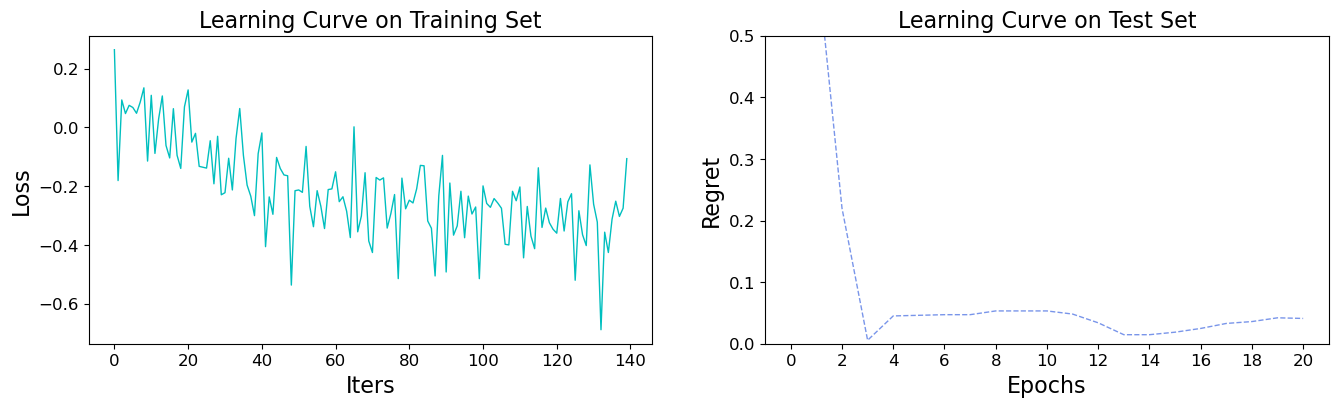

In [275]:
visLearningCurve(loss_log, loss_log_regret)

In [297]:
reg_dsl.linear.weight

Parameter containing:
tensor([[-0.8339]], dtype=torch.float64, requires_grad=True)

In [298]:
reg_dsl.linear.bias

Parameter containing:
tensor([0.9243], dtype=torch.float64, requires_grad=True)

Centralized

In [331]:
h = len(dataset_train) ** (-1/4)

# init DSL loss
dsl = DSL.DSLoss(optmodel=use_opt_model, 
                 h=h,
                 finite_diff_sch='C',
                 processes=0)

# init model
reg_dsl = LinearRegression(1,1)

## intiialization
reg_dsl.linear.weight.data = torch.tensor(reg.coef_).float()
reg_dsl.linear.bias.data = torch.tensor(reg.intercept_).float()

# cuda
if torch.cuda.is_available():
    reg = reg.cuda()
    
loss_log, loss_log_regret = trainModel(reg_dsl, 
                                       loss_func=dsl,
                                       optmodel=use_opt_model,
                                       loader_train=loader_train,
                                       loader_test=loader_test,
                                       num_epochs=20)

Num of cores: 24
Epoch  1,  Loss:   -0.2336,  Regret: 23.4954%
Epoch  2,  Loss:   -0.3580,  Regret: 18.2164%
Epoch  3,  Loss:   -0.3730,  Regret: 13.4449%
Epoch  4,  Loss:   -0.2513,  Regret:  8.1659%
Epoch  5,  Loss:   -0.6249,  Regret:  5.9324%
Epoch  6,  Loss:   -0.3687,  Regret:  4.6126%
Epoch  7,  Loss:   -0.1926,  Regret:  3.4959%
Epoch  8,  Loss:   -0.4335,  Regret:  3.2929%
Epoch  9,  Loss:    0.0863,  Regret:  3.4959%
Epoch 10,  Loss:   -0.3140,  Regret:  4.1050%
Epoch 11,  Loss:   -0.6912,  Regret:  4.2066%
Epoch 12,  Loss:   -0.2418,  Regret:  4.8157%
Epoch 13,  Loss:   -0.0944,  Regret:  5.5263%
Epoch 14,  Loss:   -0.4039,  Regret:  4.9172%
Epoch 15,  Loss:   -0.0849,  Regret:  4.7142%
Epoch 16,  Loss:   -0.2847,  Regret:  4.1050%
Epoch 17,  Loss:   -0.3924,  Regret:  4.2066%
Epoch 18,  Loss:   -0.5063,  Regret:  4.5111%
Epoch 19,  Loss:   -0.8253,  Regret:  4.2066%
Epoch 20,  Loss:   -0.3899,  Regret:  4.1050%
Total Elapsed Time: 51.05 Sec.


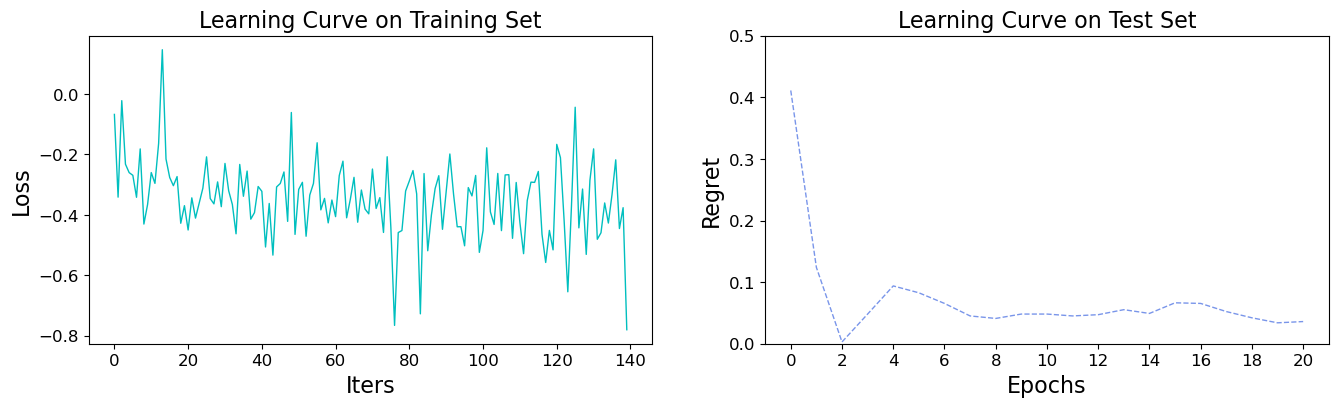

In [279]:
visLearningCurve(loss_log, loss_log_regret)

### SPO

In [336]:
spop = pyepo.func.SPOPlus(use_opt_model, processes=0)

# init model
reg_spo = LinearRegression(1,1)

## intiialization
reg_spo.linear.weight.data = torch.tensor(reg.coef_).float()
reg_spo.linear.bias.data = torch.tensor(reg.intercept_).float()

loss_log, loss_log_regret = trainModel(reg_spo, 
                                       loss_func=spop,
                                       optmodel=use_opt_model,
                                       loader_train=loader_train,
                                       loader_test=loader_test)

Epoch  1,  Loss:    1.3185,  Regret: 23.0894%
Epoch  2,  Loss:    0.9381,  Regret: 16.0845%
Epoch  3,  Loss:    0.7673,  Regret:  9.9932%
Epoch  4,  Loss:    0.9526,  Regret:  5.2218%
Epoch  5,  Loss:    0.1223,  Regret:  1.7701%
Epoch  6,  Loss:    0.2174,  Regret:  0.0767%
Epoch  7,  Loss:    0.5468,  Regret:  0.4384%
Epoch  8,  Loss:    0.9243,  Regret:  1.4310%
Epoch  9,  Loss:    1.4645,  Regret:  2.7913%
Epoch 10,  Loss:    0.5037,  Regret:  4.0274%
Epoch 11,  Loss:    1.2368,  Regret:  4.8359%
Epoch 12,  Loss:    1.0871,  Regret:  5.9596%
Epoch 13,  Loss:    1.2335,  Regret:  6.9103%
Epoch 14,  Loss:    0.4316,  Regret:  7.1552%
Epoch 15,  Loss:    0.3454,  Regret:  7.1552%
Epoch 16,  Loss:    0.2454,  Regret:  7.4117%
Epoch 17,  Loss:    0.0793,  Regret:  7.4117%
Epoch 18,  Loss:    0.6093,  Regret:  7.4117%
Epoch 19,  Loss:    0.5947,  Regret:  7.6782%
Epoch 20,  Loss:    0.0159,  Regret:  7.9497%
Total Elapsed Time: 26.40 Sec.


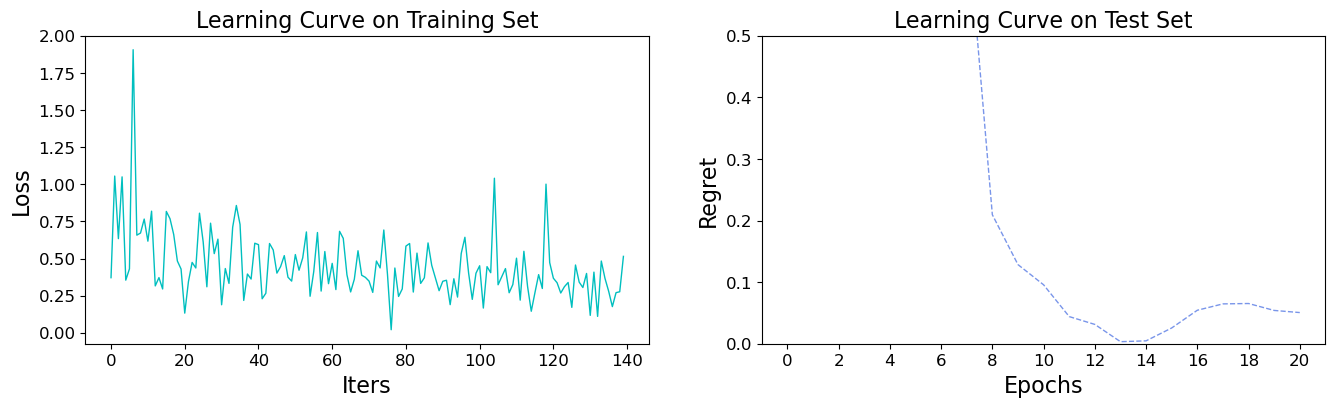

In [233]:
visLearningCurve(loss_log, loss_log_regret)

Scipy Version

In [215]:
import scipy

In [349]:
reg_raw = sk_lr().fit(x_train, y_train)

In [350]:
start = time.time()
res_dsl = scipy.optimize.minimize(dimc.DSL_loss, 
                                  (reg_raw.coef_[0][0], reg_raw.intercept_[0]), 
                                  (y_train, x_train, h))
dsl_regret = dimc.ERM_loss(res_dsl.x, exp_y_test, x_test)
dsl_regret_x = dimc.ERM_loss(res_dsl.x, exp_y_train, x_train)
dsl_time = time.time() - start
full_info_regret = np.mean(dimc.solve(exp_y_test) * exp_y_test)

In [351]:
print(f'in sample regret {dsl_regret_x}')
print(f'out sample regret {dsl_regret}')
print(f'regret {100*(full_info_regret - dsl_regret)/full_info_regret}')

in sample regret -0.3893720361648699
out sample regret -0.38103515891762463
regret 3.292883501460694


In [353]:
start = time.time()
res_dsl = scipy.optimize.minimize(dimc.SPO_loss, 
                                  (reg_raw.coef_[0][0], reg_raw.intercept_[0]), 
                                  (y_train, x_train))
dsl_regret = dimc.ERM_loss(res_dsl.x, exp_y_test, x_test)
dsl_regret_x = dimc.ERM_loss(res_dsl.x, exp_y_train, x_train)
dsl_time = time.time() - start
full_info_regret = np.mean(dimc.solve(exp_y_test) * exp_y_test)

In [354]:
print(f'in sample regret {dsl_regret_x}')
print(f'out sample regret {dsl_regret}')
print(f'regret {100*(full_info_regret - dsl_regret)/full_info_regret}')

in sample regret -0.3693720361648699
out sample regret -0.36223515891762464
regret 8.064342899950448


In [347]:
start = time.time()
res_dsl = scipy.optimize.minimize(dimc.DSL_loss, 
                                  (np.random.rand(), np.random.rand()), 
                                  (y_train, x_train, h))
dsl_regret = dimc.ERM_loss(res_dsl.x, exp_y_test, x_test)
dsl_regret_x = dimc.ERM_loss(res_dsl.x, exp_y_train, x_train)
dsl_time = time.time() - start
full_info_regret = np.mean(dimc.solve(exp_y_test) * exp_y_test)
print(f'regret {100*(full_info_regret - dsl_regret)/full_info_regret}')

regret 76.59062149528212
